In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/stylegan2"
%cd "/content/drive/My Drive/stylegan2/stylegan2"

Mounted at /content/drive
/content/drive/My Drive/stylegan2
/content/drive/My Drive/stylegan2/stylegan2


In [2]:
!ls

datasets		requirements.txt
dataset_tool.py		results
dnnlib			run_generator.py
Dockerfile		run_metrics.py
docs			run_projector.py
easy-install.sh		run_training.py
generated-0.7.zip	runway_model.py
latent-walk-v2.mp4	runway.yml
LICENSE.txt		StyleGAN2_Google_Colab_Example.ipynb
metrics			StyleGAN2_projection_interpolation.ipynb
out			StyleGAN2_Projection.ipynb
pkl			test_nvcc
pretrained_networks.py	test_nvcc.cu
projector.py		training
__pycache__		USAGE.md
README.md


In [3]:
# using this https://github.com/justinpinkney/awesome-pretrained-stylegan2#car-config-f for pretrained networks car (config-e)
%cd "/content/drive/My Drive/stylegan2/stylegan2/results/pretrained"
!wget http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-church-config-f.pkl

/content/drive/My Drive/stylegan2/stylegan2/results/pretrained
--2021-02-05 13:50:44--  http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-church-config-f.pkl
Resolving d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)... 13.32.182.63, 13.32.182.213, 13.32.182.210, ...
Connecting to d36zk2xti64re0.cloudfront.net (d36zk2xti64re0.cloudfront.net)|13.32.182.63|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 357418027 (341M) [application/x-www-form-urlencoded]
Saving to: ‘stylegan2-church-config-f.pkl’

stylegan2-church-co 100%[===================>] 340.86M  23.3MB/s    in 15s     

2021-02-05 13:51:00 (22.1 MB/s) - ‘stylegan2-church-config-f.pkl’ saved [357418027/357418027]



In [4]:
%cd "/content/drive/My Drive/stylegan2/stylegan2/"

/content/drive/My Drive/stylegan2/stylegan2


In [5]:
!ls

datasets		requirements.txt
dataset_tool.py		results
dnnlib			run_generator.py
Dockerfile		run_metrics.py
docs			run_projector.py
easy-install.sh		run_training.py
generated-0.7.zip	runway_model.py
latent-walk-v2.mp4	runway.yml
LICENSE.txt		StyleGAN2_Google_Colab_Example.ipynb
metrics			StyleGAN2_projection_interpolation.ipynb
out			StyleGAN2_Projection.ipynb
pkl			test_nvcc
pretrained_networks.py	test_nvcc.cu
projector.py		training
__pycache__		USAGE.md
README.md


In [6]:
%tensorflow_version 1.x
!pip install opensimplex

TensorFlow 1.x selected.


In [7]:
# !pip install opensimplex
# !python run_generator.py generate-images --network=/content/drive/My\ Drive/stylegan2/stylegan2/results/pretrained/network-snapshot-10000.pkl --seeds=3875451-3876000 --truncation-psi=0.7

In [8]:
%tensorflow_version 1.x
import tensorflow as tf

# Download the code
# !git clone https://github.com/NVlabs/stylegan2.git
# %cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

print('Tensorflow version: {}'.format(tf.__version__) )
!nvidia-smi -L
print('GPU Identified at: {}'.format(tf.test.gpu_device_name()))

CPU says hello.
GPU says hello.
Tensorflow version: 1.15.2
GPU 0: Tesla T4 (UUID: GPU-7ed26489-b6af-bd6a-6c9d-736af565e0b8)
GPU Identified at: /device:GPU:0


In [9]:
# Download the model of choice
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks

# Choose between these pretrained models - I think 'f' is the best choice:

# 1024×1024 faces
# stylegan2-ffhq-config-a.pkl
# stylegan2-ffhq-config-b.pkl
# stylegan2-ffhq-config-c.pkl
# stylegan2-ffhq-config-d.pkl
# stylegan2-ffhq-config-e.pkl
# stylegan2-ffhq-config-f.pkl

# 512×384 cars
# stylegan2-car-config-a.pkl
# stylegan2-car-config-b.pkl
# stylegan2-car-config-c.pkl
# stylegan2-car-config-d.pkl
# stylegan2-car-config-e.pkl
# stylegan2-car-config-f.pkl

# 256x256 horses
# stylegan2-horse-config-a.pkl
# stylegan2-horse-config-f.pkl

# 256x256 churches
# stylegan2-church-config-a.pkl
# stylegan2-church-config-f.pkl

# 256x256 cats
# stylegan2-cat-config-f.pkl
# stylegan2-cat-config-a.pkl
# network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"

# If downloads fails, due to 'Google Drive download quota exceeded' you can try downloading manually from your own Google Drive account
network_pkl = "/content/drive/My Drive/stylegan2/stylegan2/results/pretrained/stylegan2-church-config-f.pkl"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

Loading networks from "/content/drive/My Drive/stylegan2/stylegan2/results/pretrained/stylegan2-church-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.


In [10]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )





[695583 891456 974486  11575 799438  81973 892791 802739 801922]


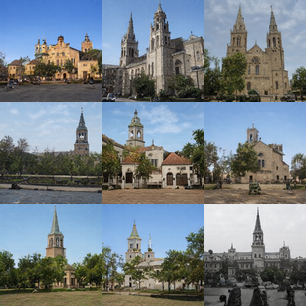

In [11]:
# generate some random seeds
seeds = np.random.randint(999999, size=9)
print(seeds)

# show the seeds
imshow(createImageGrid(generate_images_from_seeds(seeds, 0.4), 0.4 , 3))

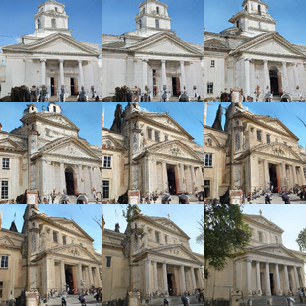

In [12]:
# Simple (Z) interpolation
zs = generate_zs_from_seeds([5046889 , 9172088 ])

latent1 = zs[0]
latent2 = zs[1]

number_of_steps = 9

imgs = generate_images(interpolate([latent1,latent2],number_of_steps), 1.0)
number_of_images = len(imgs)
imshow(createImageGrid(imgs, 0.4 , 3))

In [13]:
# generating a MP4 movie

zs = generate_zs_from_seeds([421645,6149575,3487643,3766864 ,3857159,5360657,3720613])

number_of_steps = 10
imgs = generate_images(interpolate(zs,number_of_steps), 1.0)

# Example of reading a generated set of images, and storing as MP4.
%mkdir out
movieName = 'out/mov.mp4'

with imageio.get_writer(movieName, mode='I') as writer:
    for image in log_progress(list(imgs), name = "Creating animation"):
        writer.append_data(np.array(image))

mkdir: cannot create directory ‘out’: File exists


In [14]:
# In order to download files, you can use the snippet below - this often fails for me, though, so I prefer the 'Files' browser in the sidepanel.

from google.colab import files
files.download(movieName) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('out/mov.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)